In [1]:
import autograd.numpy as np
from autograd import grad
from autograd import hessian
from scipy.optimize import linprog
from scipy.stats import ortho_group as ortho
from scipy.optimize import minimize, Bounds, LinearConstraint
import random
from matplotlib import pyplot as plt

In [158]:
class Agent:
    '''
        f_i = 0.5 x^T A x - 0.5 y^T A y + b^T (2x - y)
    '''
    def __init__(self, A, b):
        self.A = A
        self.b = b
        
    def local_func(self, x, y):
        A = self.A
        b = self.b
        value = 0.5*np.dot(x, np.dot(A,x)) - 0.5*np.dot(y, np.dot(A,y)) + np.dot(b, 2*x - y) 
        return value
    
    def local_optimum(self):
        A = self.A
        b = self.b
        x_star = - np.dot(np.linalg.inv(A), 2*b)
        y_star = - np.dot(np.linalg.inv(A), b)
        return x_star, y_star
    
    def gradient(self, x_eval, y_eval):
        dfdx = grad(self.local_func, 0)
        dfdy = grad(self.local_func, 1)
        dfdx_eval = dfdx(x_eval, y_eval)
        dfdy_eval = dfdy(x_eval, y_eval)
        return dfdx_eval, dfdy_eval
    
    def localGDA(self, x0, y0, K, lr):

        x = x0
        y = y0
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * dfdx
            y_new = y + lr * dfdy
            
            x = x_new
            y = y_new
            
        return x, y
    
    def localGDA_corr(self, x0, y0, dfndx, dfndy, K, lr):
        '''
            (x0, y0) is server's value at each outer iteration;
            (dfndx, dfndy) is gradient of global function evaluated at (x0, y0)
        '''
     
        x = x0
        y = y0
        # (dfdx_x0y0, dfdy_x0y0) is gradient of local function evaluated at (x0, y0)
        dfdx_x0y0, dfdy_x0y0 = self.gradient(x0, y0)
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * (dfdx - dfdx_x0y0 + dfndx)
            y_new = y + lr * (dfdy - dfdy_x0y0 + dfndy)
            
            x = x_new
            y = y_new
        
        return x, y

In [159]:
class Server:
    '''
        Fedminimax with GD and GD_corr
    '''
    def __init__(self, num_iter=500, num_agents=10):
        self.T = num_iter
        self.m = num_agents
        
    def value_fn(self, fi_list):
        m = self.m
        return np.sum(fi_list, axis=0) / m
        
    def gradient_fn(self, dfdx_list, dfdy_list):
        '''
            compute 1/m sum (dfi_dx(xt, yt), dfi_dy(xt, yt))
        '''
        m = self.m
        dfndx_xtyt = np.sum(dfdx_list, axis=0) / m
        dfndy_xtyt = np.sum(dfdy_list, axis=0) / m
        return dfndx_xtyt, dfndy_xtyt

# FedGDA cannot converge to optimum with fixed stepsize

In [160]:
'''
    Implementation of FedGDA and FedGDA_corr
'''
dim = 1
local_sample = 1
num_agents = 2

outer_loop_iter = 500
##########################################
# Generate agents
##########################################
agent_list = []
for i in range(num_agents):
#     alpha_i = 2 * np.random.randn(1)
#     mu_i = alpha_i + np.random.randn(dim)
#     thetai = mu_i + np.random.randn(dim)
#     Ai = np.random.randn(local_sample, dim)
#     bi = np.dot(Ai, thetai) + 0.25 * np.random.randn(local_sample)
    Ai = np.array([1.0 * (i+1)])
    Qi = np.dot(Ai.T, Ai)
#     ci = np.dot(Ai.T, bi)
    ci = np.array([- 1.0 * (i + 1) - i * 30.0])
    agent_list.append(Agent(Qi, ci))

##########################################
# Generate server
##########################################
# server = Server(outer_loop_iter, num_agents)


##########################################
# Global optimum
##########################################
Qg = np.zeros((dim, dim))
cg = np.zeros(dim)
for i in range(num_agents):
    Qg = Qg + agent_list[i].A
    cg = cg + agent_list[i].b
    
x_star = - np.dot(np.linalg.inv(Qg), 2 * cg)
y_star = - np.dot(np.linalg.inv(Qg), cg)

f_star = 0.0
for i in range(num_agents):
    f_star = f_star + agent_list[i].local_func(x_star, y_star)
f_star = f_star / num_agents

In [161]:
'''
    GDA with K = 1
'''

inner_loop_iter = 1
lr = 0.1

##########################################
# FedGDA
##########################################

# Initialization
x0 = np.random.randn(dim)
y0 = np.random.randn(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
errfn_his_1 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr / inner_loop_iter)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_1.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

In [162]:
'''
    K = 10
'''
inner_loop_iter = 10
lr = 0.001

xt_his = [x0]
yt_his = [y0]
errfn_his_10 = []


xt = x0
yt = y0
# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_10.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

In [163]:
'''
    K = 20
'''
inner_loop_iter = 20
lr = 0.001

xt_his = [x0]
yt_his = [y0]
errfn_his_20 = []


xt = x0
yt = y0
# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

In [164]:
'''
    K = 50
'''
inner_loop_iter = 50
lr = 0.001

xt_his = [x0]
yt_his = [y0]
errfn_his_50 = []

xt = x0
yt = y0
# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_50.append(np.linalg.norm(fn_t / num_agents - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


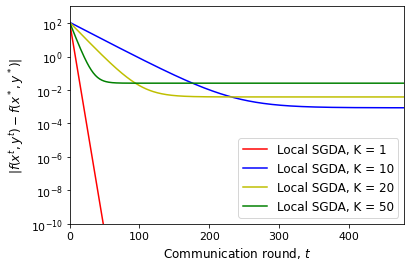

In [314]:
fig = plt.figure()
plt.plot(errfn_his_1, 'r')
plt.plot(errfn_his_10, 'b')
plt.plot(errfn_his_20, 'y')
plt.plot(errfn_his_50, 'g')
plt.xlim([0, 480])
plt.ylim([1e-10, 1e3])
plt.yscale("log")
plt.legend(["Local SGDA, K = 1", "Local SGDA, K = 10", "Local SGDA, K = 20", "Local SGDA, K = 50"], fontsize=12)
plt.xlabel("Communication round, $t$", fontsize=12)
plt.ylabel("$|f(x^t, y^t) - f(x^*, y^*)|$",fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('FedGDA_fails.eps')

# FedGDA-corr with synthetic data

In [323]:
class Agent:
    '''
        f_i = 0.5 x^T A x - 0.5 y^T A y + b^T (2x - y)
    '''
    def __init__(self, A, b):
        self.A = A
        self.b = b
        
    def local_func(self, x, y):
        A = self.A
        b = self.b
        value = 0.5*np.dot(x, np.dot(A,x)) - 0.5*np.dot(y, np.dot(A,y)) + np.dot(b, 2 * x - y) 
        return value
    
    def local_optimum(self):
        A = self.A
        b = self.b
        x_star = - np.dot(np.linalg.inv(A), 2*b)
        y_star = - np.dot(np.linalg.inv(A), b)
        return x_star, y_star
    
    def gradient(self, x_eval, y_eval):
        dfdx = grad(self.local_func, 0)
        dfdy = grad(self.local_func, 1)
        dfdx_eval = dfdx(x_eval, y_eval)
        dfdy_eval = dfdy(x_eval, y_eval)
        return dfdx_eval, dfdy_eval
    
    def localGDA(self, x0, y0, K, lr):

        x = x0
        y = y0
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * dfdx
            y_new = y + lr * dfdy
            
            x = x_new
            y = y_new
            
        return x, y
    
    def localGDA_corr(self, x0, y0, dfndx, dfndy, K, lr):
        '''
            (x0, y0) is server's value at each outer iteration;
            (dfndx, dfndy) is gradient of global function evaluated at (x0, y0)
        '''
     
        x = x0
        y = y0
        # (dfdx_x0y0, dfdy_x0y0) is gradient of local function evaluated at (x0, y0)
        dfdx_x0y0, dfdy_x0y0 = self.gradient(x0, y0)
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * (dfdx - dfdx_x0y0 + dfndx)
            y_new = y + lr * (dfdy - dfdy_x0y0 + dfndy)
            
            x = x_new
            y = y_new
        
        return x, y

In [330]:
'''
    Implementation of FedGDA and FedGDA_corr
'''
dim = 50
local_sample = 500
num_agents = 20

outer_loop_iter =500
##########################################
# Generate agents
##########################################
agent_list = []
for i in range(num_agents):
    alpha_i = 10.0 * np.random.randn(1)
    mu_i = alpha_i + np.random.randn(dim)
    thetai = mu_i + np.random.randn(dim)
    Ai = np.random.randn(local_sample, dim) / (0.5 * (i + 1))
    bi = np.dot(Ai, thetai) + 0.25 * np.random.randn(local_sample)
    Qi = np.dot(Ai.T, Ai)
    ci = np.dot(Ai.T, bi)
    agent_list.append(Agent(Qi, ci))

##########################################
# Generate server
##########################################
# server = Server(outer_loop_iter, num_agents)


##########################################
# Global optimum
##########################################
Qg = np.zeros((dim, dim))
cg = np.zeros(dim)
for i in range(num_agents):
    Qg = Qg + agent_list[i].A
    cg = cg + agent_list[i].b
    
x_star = - np.dot(np.linalg.inv(Qg), 2*cg)
y_star = - np.dot(np.linalg.inv(Qg), cg)

f_star = 0.0
for i in range(num_agents):
    f_star = f_star + agent_list[i].local_func(x_star, y_star)
f_star = f_star / num_agents

In [331]:
'''
    FedGDA with K = 1 (baseline)
'''

inner_loop_iter = 1
lr = 1e-4

##########################################
# FedGDA
##########################################

# Initialization
x0 = np.random.randn(dim)
y0 = np.random.randn(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
errfn_his_GDA = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_GDA.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

In [340]:
'''
    FedGDA with K = 20
'''

inner_loop_iter = 50
lr = 1e-4

##########################################
# FedGDA
##########################################

# Initialization
x0 = np.random.randn(dim)
y0 = np.random.randn(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
errfn_his_GDA20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_GDA20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

In [341]:
'''
    FedGDA-corr with K = 20
'''

inner_loop_iter = 50
lr = 1e-4

##########################################
# FedGDA-corr
##########################################

# Initialization
x0 = np.random.randn(dim)
y0 = np.random.randn(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
errfn_his_GDAcorr20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    # compute dfndx and dfndy at (xt, yt)
    dfndx_xtyt = np.zeros(dim)
    dfndy_xtyt = np.zeros(dim)
    for i in range(num_agents):
        dfidx_xtyt, dfidy_xtyt = agent_list[i].gradient(xt, yt)
        dfndx_xtyt = dfndx_xtyt + dfidx_xtyt
        dfndy_xtyt = dfndy_xtyt + dfidy_xtyt
    dfndx_xtyt = dfndx_xtyt / num_agents
    dfndy_xtyt = dfndy_xtyt / num_agents
    
    
    fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
        fi_xtyt = agent_i.local_func(xt, yt)
        fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA_corr(xt, yt, dfndx_xtyt, dfndy_xtyt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
    xt_his.append(xt)
    yt_his.append(yt)
    
    errfn_his_GDAcorr20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


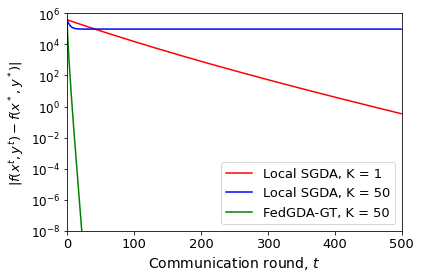

In [342]:
fig = plt.figure()
plt.plot(errfn_his_GDA, 'r')
plt.plot(errfn_his_GDA20, 'b')
plt.plot(errfn_his_GDAcorr20, 'g')
plt.xlim([0, outer_loop_iter])
plt.ylim([1e-8, 1e6])
plt.yscale("log")
plt.legend(["Local SGDA, K = 1", "Local SGDA, K = 50", "FedGDA-GT, K = 50"],fontsize=13)
plt.xlabel("Communication round, $t$",fontsize=14)
plt.ylabel("$| f(x^t, y^t) - f(x^*, y^*)| $",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.savefig('FedGDA-corr_vs_FedGDA_synthetic50.eps')

# FedGDA-corr with robust linear regression

In [263]:
class Agent:
    '''
        f_i = 1/n \sum (w^T(xj + \delta) - yj)^2 + 0.5 w^T w
        yj = w^T xj + epsilonj
        
    '''
    def __init__(self, num_samples, mu, var, noise_var, w_star):
        self.n = num_samples
        self.input_mean = mu
        self.input_var = var
        self.noise = noise_var
        self.w_star = w_star
        
    def local_func(self, w, delta):
        n = self.n
        x_mean = self.input_mean
        x_var = self.input_var
        noise_var = self.noise
        w_star = self.w_star
        
        # Generate data
        x = np.random.multivariate_normal(x_mean, x_var, n)
        y = np.dot(x, w_star) + noise_var * np.random.randn(n)
        # Local loss function
        value = np.sum((np.dot(x + np.dot(np.ones((n, 1)), delta[np.newaxis, :]), w) - y) ** 2) / n + 0.5 * np.dot(w, w)
        
        return value
    
    def gradient(self, x_eval, y_eval):
        dfdx = grad(self.local_func, 0)
        dfdy = grad(self.local_func, 1)
        dfdx_eval = dfdx(x_eval, y_eval)
        dfdy_eval = dfdy(x_eval, y_eval)
        return dfdx_eval, dfdy_eval
    
    def localGDA(self, x0, y0, K, lr):

        x = x0
        y = y0
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * dfdx
            y_new = y + lr * dfdy
            
            x = x_new
            y = y_new
            
        return x, y
    
    def localGDA_corr(self, x0, y0, dfndx, dfndy, K, lr):
        '''
            (x0, y0) is server's value at each outer iteration;
            (dfndx, dfndy) is gradient of global function evaluated at (x0, y0)
        '''
     
        x = x0
        y = y0
        # (dfdx_x0y0, dfdy_x0y0) is gradient of local function evaluated at (x0, y0)
        dfdx_x0y0, dfdy_x0y0 = self.gradient(x0, y0)
        for k in range(K):
            dfdx, dfdy = self.gradient(x, y)
            x_new = x - lr * (dfdx - dfdx_x0y0 + dfndx)
            y_new = y + lr * (dfdy - dfdy_x0y0 + dfndy)
            
            x = x_new
            y = y_new
        
        return x, y

    

In [264]:
from scipy.optimize import NonlinearConstraint as NLC
from scipy.optimize import minimize

class Server:
    
    def __init__(self, agent_list):
        self.agent_list = agent_list
        self.m = len(agent_list)
        
    def global_obj(self, x, y):
        agent_list = self.agent_list
        m = self.m
        
        value = 0.0
        for i in range(m):
            value = value + agent_list[i].local_func(x, y)
            
        value = value / m
        return value
    
    def global_grad(self, x_eval, y_eval):
        dfdx = grad(self.global_obj, 0)
        dfdy = grad(self.global_obj, 1)
        dfdx_eval = dfdx(x_eval, y_eval)
        dfdy_eval = dfdy(x_eval, y_eval)
        return dfdx_eval, dfdy_eval
    
    def proj(self, x_t, constraints_bd):
        con = lambda x: np.dot(x, x)
        nlc = NLC(con, 0.0, constraints_bd ** 2)
        dis = lambda x: np.dot(x - x_t, x - x_t)
        res = minimize(fun=dis, x0=x_t, constraints=nlc)
        return res.x
    
    def robust_loss(self, x_eval, y0, K, lr, con_bd):
        y = y0
        for k in range(K):
            dfdx, dfdy = self.global_grad(x_eval, y)
            y_new = y + lr * dfdy
            y = self.proj(y_new, con_bd)
            
        robust_loss_x_eval = self.global_obj(x_eval, y)
        return robust_loss_x_eval

## FedGDA-corr with robust linear regression (alpha = 10)

In [91]:
'''
    Implementation of FedGDA and FedGDA_corr with alpha = 10.0
'''
dim = 10
local_sample = 200
num_agents = 20

##########################################
# Generate agents
##########################################
alpha = 10.0
agent_list = []
for i in range(num_agents):
    wi_star = np.random.randn(dim)
    noise_var_i = np.random.randn()
    Mi = alpha * np.random.randn() * np.ones(dim)
    mu_i = np.random.multivariate_normal(Mi, np.eye(dim))
    cov_i = (i + 1.0) ** (-1.3) * np.eye(dim)
    
    agent_list.append(Agent(local_sample, mu_i, cov_i, noise_var_i, wi_star))

##########################################
# Generate server
##########################################
# Generate the Server
server = Server(agent_list)

In [92]:
outer_loop_iter = 100
# Initialization

In [24]:
##########################################
# Get Optimal value by running GDA (K=1) for 100 times
##########################################
lr = 1e-6
K = 1
x0 = np.random.randn(dim)
y0 = np.random.randn(dim)
f_star_his = []
for l in range(100):
#     x0 = np.random.randn(dim)
#     y0 = np.random.randn(dim)
    xt = x0
    yt = y0

    xt_his = [x0]
    yt_his = [y0]
    fn_his = []
    # Get f^*
    for t in range(outer_loop_iter):
        localUpdate_x = []
        localUpdate_y = []
    
    
        fn_t = 0.0
        for i in range(len(agent_list)):
            agent_i = agent_list[i]
        
            # compute fn(xt, yt)
            fi_xtyt = agent_i.local_func(xt, yt)
            fn_t = fn_t + fi_xtyt
        
            # local update
            xi_last, yi_last = agent_i.localGDA(xt, yt, K, lr)
        
            # store the output of agent i
            localUpdate_x.append(xi_last)
            localUpdate_y.append(yi_last)
        
        xt = np.sum(localUpdate_x, axis=0) / num_agents
        yt = np.sum(localUpdate_y, axis=0) / num_agents 
    
        xt_his.append(xt)
        yt_his.append(yt)
    
        fn_his.append(fn_t / num_agents)
        
    f_star_l = np.sum(fn_his[-int(0.05* outer_loop_iter):]) / (int(0.05 * outer_loop_iter))
    f_star_his.append(f_star_l)
        

In [26]:
# Optimal value
f_star = np.sum(f_star_his) / len(f_star_his)

In [93]:
##################################
# FedGDA (K = 20)
##################################
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

# x0 = np.random.randn(dim)
# y0 = np.random.randn(dim)
x0 = np.zeros(dim)
y0 = np.zeros(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
# RLR_err_his_GDA20 = []
RLR_robustloss_GDA20 = []

for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
    fn_t = server.global_obj(xt, yt)
    
    # robust loss at xt
    robust_loss_xt = server.robust_loss(xt, yt, 100, 1e-4, con_bd)
    RLR_robustloss_GDA20.append(robust_loss_xt)
#     fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
        # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDA20.append(np.linalg.norm(fn_t / (num_agents) - f_star))
    

In [94]:
'''
    FedGDA-corr with K = 20
'''
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

##########################################
# FedGDA-corr (K = 20)
##########################################

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
RLR_robustloss_GDAcorr20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     # compute dfndx and dfndy at (xt, yt)
#     dfndx_xtyt = np.zeros(dim)
#     dfndy_xtyt = np.zeros(dim)
#     for i in range(num_agents):
#         dfidx_xtyt, dfidy_xtyt = agent_list[i].gradient(xt, yt)
#         dfndx_xtyt = dfndx_xtyt + dfidx_xtyt
#         dfndy_xtyt = dfndy_xtyt + dfidy_xtyt
#     dfndx_xtyt = dfndx_xtyt / num_agents
#     dfndy_xtyt = dfndy_xtyt / num_agents

    dfndx_xtyt, dfndy_xtyt = server.global_grad(xt, yt)
    
    # compute robust loss
    robust_loss_xt = server.robust_loss(xt, yt, 100, 1e-4, con_bd)
    RLR_robustloss_GDAcorr20.append(robust_loss_xt)
    
#     fn_t = 0.0
    for i in range(len(agent_list)):
        agent_i = agent_list[i]
        
#         # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA_corr(xt, yt, dfndx_xtyt, dfndy_xtyt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDAcorr20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


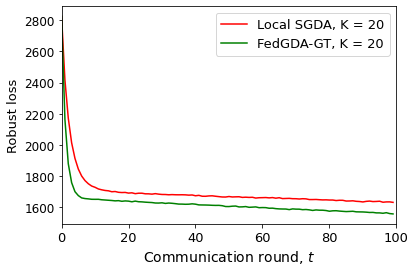

In [338]:
plt.plot(RLR_robustloss_GDA20, 'r')
plt.plot(RLR_robustloss_GDAcorr20, 'g')
plt.xlim([0, 100])
# plt.ylim([1e-9, 1e6])
# plt.yscale("log")
plt.legend(["Local SGDA, K = 20", "FedGDA-GT, K = 20"],fontsize=13)
plt.xlabel("Communication round, $t$",fontsize=14)
plt.ylabel("Robust loss",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.savefig('FedGDA-corr_vs_FedGDA_RLR_alpha10.eps')

## FedGDA-corr with robust linear regression (alpha = 20)

In [270]:
'''
    Implementation of FedGDA and FedGDA_corr with alpha = 20.0
'''
dim = 10
local_sample = 200
num_agents = 20

##########################################
# Generate agents
##########################################
alpha = 25.0
agent_list_20 = []
for i in range(num_agents):
    wi_star = np.random.randn(dim)
    noise_var_i = np.random.randn()
    Mi = alpha * np.random.randn() * np.ones(dim)
    mu_i = np.random.multivariate_normal(Mi, np.eye(dim))
    cov_i = (i + 1.0) ** (-1.3) * np.eye(dim)
    
    agent_list_20.append(Agent(local_sample, mu_i, cov_i, noise_var_i, wi_star))

##########################################
# Generate server
##########################################
# Generate the Server
server_20 = Server(agent_list_20)

In [271]:
outer_loop_iter = 200

In [272]:
##################################
# FedGDA (K = 20)
##################################
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

# x0 = np.random.randn(dim)
# y0 = np.random.randn(dim)
x0 = np.zeros(dim)
y0 = np.zeros(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
# RLR_err_his_GDA20 = []
RLR20_robustloss_GDA20 = []

for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     fn_t = server_20.global_obj(xt, yt)
    
    # robust loss at xt
    robust_loss_xt = server_20.robust_loss(xt, yt, 50, 1e-4, con_bd)
    RLR20_robustloss_GDA20.append(robust_loss_xt)
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_20[i]
        
        # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDA20.append(np.linalg.norm(fn_t / (num_agents) - f_star))
    

In [273]:
'''
    FedGDA-corr with K = 20
'''
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

##########################################
# FedGDA-corr (K = 20)
##########################################

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
RLR20_robustloss_GDAcorr20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     # compute dfndx and dfndy at (xt, yt)
#     dfndx_xtyt = np.zeros(dim)
#     dfndy_xtyt = np.zeros(dim)
#     for i in range(num_agents):
#         dfidx_xtyt, dfidy_xtyt = agent_list[i].gradient(xt, yt)
#         dfndx_xtyt = dfndx_xtyt + dfidx_xtyt
#         dfndy_xtyt = dfndy_xtyt + dfidy_xtyt
#     dfndx_xtyt = dfndx_xtyt / num_agents
#     dfndy_xtyt = dfndy_xtyt / num_agents

    dfndx_xtyt, dfndy_xtyt = server_20.global_grad(xt, yt)
    
    # compute robust loss
    robust_loss_xt = server_20.robust_loss(xt, yt, 50, 1e-4, con_bd)
    RLR20_robustloss_GDAcorr20.append(robust_loss_xt)
    
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_20[i]
        
#         # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA_corr(xt, yt, dfndx_xtyt, dfndy_xtyt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDAcorr20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


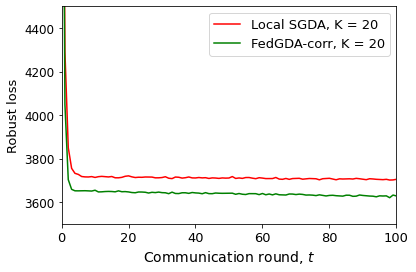

In [337]:
plt.plot(RLR20_robustloss_GDA20, 'r')
plt.plot(RLR20_robustloss_GDAcorr20, 'g')
plt.xlim([0, 100])
plt.ylim([3500, 4500])
# plt.yscale("log")
plt.legend(["Local SGDA, K = 20", "FedGDA-corr, K = 20"],fontsize=13)
plt.xlabel("Communication round, $t$",fontsize=14)
plt.ylabel("Robust loss",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.savefig('FedGDA-corr_vs_FedGDA_RLR_alpha20.eps')

## FedGDA-corr with robust linear regression (alpha = 1.0)

In [179]:
'''
    Implementation of FedGDA and FedGDA_corr with alpha = 1.0
'''
dim = 10
local_sample = 200
num_agents = 20

##########################################
# Generate agents
##########################################
alpha = 1.0
agent_list_1 = []
for i in range(num_agents):
    wi_star = np.random.randn(dim)
    noise_var_i = np.random.randn()
    Mi = alpha * np.random.randn() * np.ones(dim)
    mu_i = np.random.multivariate_normal(Mi, np.eye(dim))
    cov_i = (i + 1.0) ** (-1.3) * np.eye(dim)
    
    agent_list_1.append(Agent(local_sample, mu_i, cov_i, noise_var_i, wi_star))

##########################################
# Generate server
##########################################
# Generate the Server
server_1 = Server(agent_list_1)

In [180]:
outer_loop_iter = 200

In [181]:
##################################
# FedGDA (K = 20)
##################################
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

x0 = np.random.randn(dim)
y0 = np.random.randn(dim)
# x0 = np.zeros(dim)
# y0 = np.zeros(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
# RLR_err_his_GDA20 = []
RLR1_robustloss_GDA20 = []

for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     fn_t = server_20.global_obj(xt, yt)
    
    # robust loss at xt
    robust_loss_xt = server_1.robust_loss(xt, yt, 200, 5e-3, con_bd)
    RLR1_robustloss_GDA20.append(robust_loss_xt)
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_1[i]
        
        # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDA20.append(np.linalg.norm(fn_t / (num_agents) - f_star))
    

In [182]:
'''
    FedGDA-corr with K = 20
'''
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

##########################################
# FedGDA-corr (K = 20)
##########################################

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
RLR1_robustloss_GDAcorr20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     # compute dfndx and dfndy at (xt, yt)
#     dfndx_xtyt = np.zeros(dim)
#     dfndy_xtyt = np.zeros(dim)
#     for i in range(num_agents):
#         dfidx_xtyt, dfidy_xtyt = agent_list[i].gradient(xt, yt)
#         dfndx_xtyt = dfndx_xtyt + dfidx_xtyt
#         dfndy_xtyt = dfndy_xtyt + dfidy_xtyt
#     dfndx_xtyt = dfndx_xtyt / num_agents
#     dfndy_xtyt = dfndy_xtyt / num_agents

    dfndx_xtyt, dfndy_xtyt = server_1.global_grad(xt, yt)
    
    # compute robust loss
    robust_loss_xt = server_1.robust_loss(xt, yt, 200,5e-3, con_bd)
    RLR1_robustloss_GDAcorr20.append(robust_loss_xt)
    
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_1[i]
        
#         # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA_corr(xt, yt, dfndx_xtyt, dfndy_xtyt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDAcorr20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


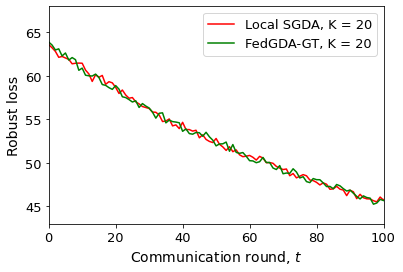

In [321]:
plt.plot(RLR1_robustloss_GDA20, 'r')
plt.plot(RLR1_robustloss_GDAcorr20, 'g')
plt.xlim([0, 100])
plt.ylim([43, 68])
# plt.yscale("log")
plt.legend(["Local SGDA, K = 20", "FedGDA-GT, K = 20"],fontsize=13)
plt.xlabel("Communication round, $t$",fontsize=14)
plt.ylabel("Robust loss",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('FedGDA-corr_vs_FedGDA_RLR_alpha1.eps')

## FedGDA-corr with robust linear regression (alpha = 5.0)

In [174]:
'''
    Implementation of FedGDA and FedGDA_corr with alpha = 20.0
'''
dim = 10
local_sample = 200
num_agents = 20

##########################################
# Generate agents
##########################################
alpha = 5.0
agent_list_5 = []
for i in range(num_agents):
    wi_star = np.random.randn(dim)
    noise_var_i = np.random.randn()
    Mi = alpha * np.random.randn() * np.ones(dim)
    mu_i = np.random.multivariate_normal(Mi, np.eye(dim))
    cov_i = (i + 1.0) ** (-1.3) * np.eye(dim)
    
    agent_list_5.append(Agent(local_sample, mu_i, cov_i, noise_var_i, wi_star))

##########################################
# Generate server
##########################################
# Generate the Server
server_5 = Server(agent_list_5)

In [175]:
outer_loop_iter = 200

In [176]:
##################################
# FedGDA (K = 20)
##################################
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

# x0 = np.random.randn(dim)
# y0 = np.random.randn(dim)
x0 = np.zeros(dim)
y0 = np.zeros(dim)

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
# RLR_err_his_GDA20 = []
RLR5_robustloss_GDA20 = []

for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     fn_t = server_20.global_obj(xt, yt)
    
    # robust loss at xt
    robust_loss_xt = server_5.robust_loss(xt, yt, 100, 2e-4, con_bd)
    RLR5_robustloss_GDA20.append(robust_loss_xt)
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_5[i]
        
        # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA(xt, yt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDA20.append(np.linalg.norm(fn_t / (num_agents) - f_star))
    

In [177]:
'''
    FedGDA-corr with K = 20
'''
con_bd = 1.0
inner_loop_iter = 20
lr = 1e-5

##########################################
# FedGDA-corr (K = 20)
##########################################

xt = x0
yt = y0

xt_his = [x0]
yt_his = [y0]
RLR5_robustloss_GDAcorr20 = []

# Get f^*
for t in range(outer_loop_iter):
    localUpdate_x = []
    localUpdate_y = []
    
#     # compute dfndx and dfndy at (xt, yt)
#     dfndx_xtyt = np.zeros(dim)
#     dfndy_xtyt = np.zeros(dim)
#     for i in range(num_agents):
#         dfidx_xtyt, dfidy_xtyt = agent_list[i].gradient(xt, yt)
#         dfndx_xtyt = dfndx_xtyt + dfidx_xtyt
#         dfndy_xtyt = dfndy_xtyt + dfidy_xtyt
#     dfndx_xtyt = dfndx_xtyt / num_agents
#     dfndy_xtyt = dfndy_xtyt / num_agents

    dfndx_xtyt, dfndy_xtyt = server_5.global_grad(xt, yt)
    
    # compute robust loss
    robust_loss_xt = server_5.robust_loss(xt, yt, 100, 2e-4, con_bd)
    RLR5_robustloss_GDAcorr20.append(robust_loss_xt)
    
#     fn_t = 0.0
    for i in range(num_agents):
        agent_i = agent_list_5[i]
        
#         # compute fn(xt, yt)
#         fi_xtyt = agent_i.local_func(xt, yt)
#         fn_t = fn_t + fi_xtyt
        
        # local update
        xi_last, yi_last = agent_i.localGDA_corr(xt, yt, dfndx_xtyt, dfndy_xtyt, inner_loop_iter, lr)
        
        # store the output of agent i
        localUpdate_x.append(xi_last)
        localUpdate_y.append(yi_last)
        
    xt = np.sum(localUpdate_x, axis=0) / num_agents
    yt = server.proj(np.sum(localUpdate_y, axis=0) / num_agents , con_bd)
    
    xt_his.append(xt)
    yt_his.append(yt)
    
#     RLR_err_his_GDAcorr20.append(np.linalg.norm(fn_t / (num_agents) - f_star))

    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


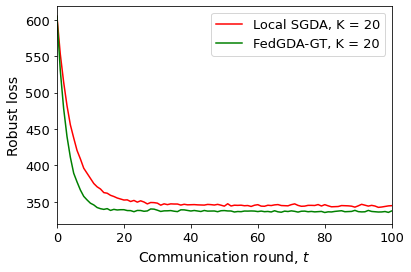

In [322]:
plt.plot(RLR5_robustloss_GDA20, 'r')
plt.plot(RLR5_robustloss_GDAcorr20, 'g')
plt.xlim([0, 100])
# plt.ylim([55, 68])
# plt.yscale("log")
plt.legend(["Local SGDA, K = 20", "FedGDA-GT, K = 20"],fontsize=13)
plt.xlabel("Communication round, $t$",fontsize=14)
plt.ylabel("Robust loss",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('FedGDA-corr_vs_FedGDA_RLR_alpha5.eps')